In [3]:
from main import get_preprocessed_data
from indicator_and_strategy.indicators import Indicator
from indicator_and_strategy.momentumstrategy import MomentumStrategy
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import talib
import datetime as dt

from finrl.meta.preprocessor.yahoodownloader import  YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS
import itertools


plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dollar PnL calculation

pnls = []
dates = []
entry = None
for i in range(len(df)):
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = entry - df['close'].iloc[i]
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]

    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = df['close'].iloc[i] - entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]


# Percentage PnL calculation
pnls = []
dates = []
entry = None
for i in range(len(df)):
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = (entry - df['close'].iloc[i]) / entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]


    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = (df['close'].iloc[i] - entry) / entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]

# Plotting Unrealized PnL 

entry = None
pnls = []
dates = []
inpos = 0
unrlzd = []
urlzd_dates = []
hold_time = []
for i in range(len(df)):
    unr = (spy.iloc[i] -spy.iloc[i - 1]) * inpos
    unrlzd.append(unr)
    urlzd_dates.append(df.index[i])
    hold_time.append((df['close'].index[i] - start).days)
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = entry - spy.iloc[i]
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].index[i]
        inpos = 1
        start = df.index[i]

    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = spy.iloc[i] - entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]
        inpos = -1
        start = df['close'].index[i]

plt.figure(figsize=(16,8))
plt.title('Unrealized PnL vs Realized PnL')
plt.plot(urlzd_dates, np.cumsum(unrlzd))
plt.plot(dates, np.cumsum(pnls), '-o')


# Quantifying the strategy: How good is it?

sharp_ratio = np.mean(unrlzd) / np.std(unrlzd) * np.sqrt(252)
print(f'Annualized Sharpe Ratio: {sharp_ratio}')

sharp_ratio = np.mean(unrlzd) / np.std(unrlzd) * 16
print(f'Annualized Sharpe Ratio: {sharp_ratio}')

In [4]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [5]:
symbols = [
    'aapl', 
    'msft',
    'meta',
    'ibm'
]

In [6]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = symbols
                     ).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (13569, 8)


In [7]:
df_raw.head(10)

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.740173,746015200,aapl,4
1,2009-01-02,80.200768,83.738052,80.200768,49.160149,7905877,ibm,4
2,2009-01-02,19.530001,20.400000,19.370001,15.011639,50084000,msft,4
3,2009-01-05,3.327500,3.435000,3.311071,2.855819,1181608400,aapl,0
4,2009-01-05,82.619499,83.814529,82.390060,48.850681,8698222,ibm,0
5,2009-01-05,20.200001,20.670000,20.059999,15.151946,61475200,msft,0
6,2009-01-06,3.426786,3.470357,3.299643,2.808713,1289310400,aapl,1
7,2009-01-06,83.279160,86.434036,82.571701,50.206703,10093377,ibm,1
8,2009-01-06,20.750000,21.000000,20.610001,15.329155,58083400,msft,1
9,2009-01-07,3.278929,3.303571,3.223571,2.748023,753048800,aapl,2


In [8]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)
df = fe.preprocess_data(df_raw)
df.head()

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3604, 8)
Successfully added vix
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.740173,746015200,aapl,4,0.000000,2.961544,2.634448,100.0,66.666667,100.0,2.740173,2.740173,39.189999,0.0
1,2009-01-02,80.200768,83.738052,80.200768,49.160149,7905877,ibm,4,0.000000,2.961544,2.634448,100.0,66.666667,100.0,49.160149,49.160149,39.189999,0.0
2,2009-01-02,19.530001,20.400000,19.370001,15.011639,50084000,msft,4,0.000000,2.961544,2.634448,100.0,66.666667,100.0,15.011639,15.011639,39.189999,0.0
3,2009-01-05,3.327500,3.435000,3.311071,2.855819,1181608400,aapl,0,0.002595,2.961544,2.634448,100.0,66.666667,100.0,2.797996,2.797996,39.080002,0.0
4,2009-01-05,82.619499,83.814529,82.390060,48.850681,8698222,ibm,0,-0.006943,49.443068,48.567762,0.0,66.666667,100.0,49.005415,49.005415,39.080002,0.0


In [9]:
list_ticker = df['tic'].unique().tolist()
list_date = list(pd.date_range(df['date'].min(), df['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

procesed_df = pd.DataFrame(combination, columns=['date', 'tic']).merge(df, on=['date', 'tic'], how='left')
procesed_df = procesed_df[procesed_df['date'].isin(df['date'])]
procesed_df = procesed_df.sort_values(['date', 'tic'])
procesed_df = procesed_df.fillna(0)


In [10]:
procesed_df.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,aapl,3.067143,3.251429,3.041429,2.740173,7.460152e+08,4.0,0.000000,2.961544,2.634448,100.0,66.666667,100.0,2.740173,2.740173,39.189999,0.0
1,2009-01-02,ibm,80.200768,83.738052,80.200768,49.160149,7.905877e+06,4.0,0.000000,2.961544,2.634448,100.0,66.666667,100.0,49.160149,49.160149,39.189999,0.0
2,2009-01-02,msft,19.530001,20.400000,19.370001,15.011639,5.008400e+07,4.0,0.000000,2.961544,2.634448,100.0,66.666667,100.0,15.011639,15.011639,39.189999,0.0
9,2009-01-05,aapl,3.327500,3.435000,3.311071,2.855819,1.181608e+09,0.0,0.002595,2.961544,2.634448,100.0,66.666667,100.0,2.797996,2.797996,39.080002,0.0
10,2009-01-05,ibm,82.619499,83.814529,82.390060,48.850681,8.698222e+06,0.0,-0.006943,49.443068,48.567762,0.0,66.666667,100.0,49.005415,49.005415,39.080002,0.0


In [11]:
train = data_split(procesed_df, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(procesed_df, TRADE_START_DATE, TRADE_END_DATE)

print(len(train))
print(len(trade))


8679
2133


In [12]:
from pathlib import Path

In [18]:
train.to_csv(Path.cwd() / 'train.csv')
trade.to_csv(Path.cwd() / 'trade.csv')

In [19]:
# Traing part of Finrl:

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

check_and_make_directories([TRAINED_MODEL_DIR])

In [29]:

stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f'Number of Stock: {stock_dimension} || State Space: {state_space}')

Number of Stock: 3 || State Space: 31


In [36]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

In [52]:
env_kwargs = {
    'hmax': 100,    # the maximum number of shares that can be purchased at each step
    'initial_amount': 1000000, 
    'num_stock_shares': num_stock_shares,
    'buy_cost_pct': buy_cost_list,
    'sell_cost_pct': sell_cost_list,
    'state_space': state_space,
    'stock_dim': stock_dimension,
    'tech_indicator_list': INDICATORS,
    'action_space': stock_dimension,
    'reward_scaling': 1e-4
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)   # This is state-space representation of the env


In [53]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [61]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False
if_using_ddpg = False
if_using_dqn = False
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False
if_using_dqn = False
if_using_a2c = True
if_using_ddpg = False

In [62]:
model_a2c = agent.get_model("a2c")
model_ppo = agent.get_model("ppo")

if if_using_a2c:
    tmp_path = TRAINED_MODEL_DIR + 'a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_a2c)

if if_using_dqn:
    tmp_path = TRAINED_MODEL_DIR + 'ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_ppo)

    

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to trained_modelsa2c


In [65]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 587         |
|    iterations         | 100         |
|    time_elapsed       | 0           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -4.5        |
|    explained_variance | 0.209       |
|    learning_rate      | 0.0007      |
|    n_updates          | 10099       |
|    policy_loss        | -2.43       |
|    reward             | 0.075249605 |
|    std                | 1.09        |
|    value_loss         | 0.399       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 578       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -4.48     |
|    explained_variance | 0.185     |
|    learning_rate

In [66]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c, 
                        environment = e_train_gym)

hit end!


<Axes: >

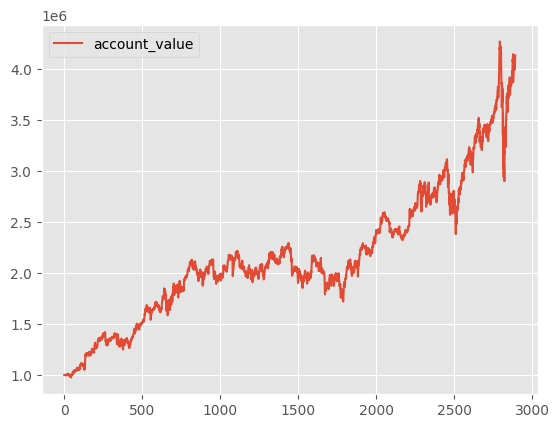

In [71]:
df_account_value_a2c.plot()


In [86]:
len(df_actions_a2c[df_actions_a2c['inm'] >= 100 ])

0

In [81]:
df_actions_a2c

,aapl,ibm,msft
date,,,
2009-01-02,0,100,100
2009-01-05,0,100,100
2009-01-06,0,100,100
2009-01-07,0,100,100
2009-01-08,0,100,100
...,...,...,...
2020-06-23,0,0,0
2020-06-24,0,0,0
2020-06-25,0,0,0


In [136]:
import ccxt
import datetime as dt
import pandas as pd
ex = ccxt.binance()

df_rrw = ex.fetch_ohlcv('BTC/USDT', '1d', since=1496787634826, limit=100000)

In [150]:
df = pd.DataFrame(df_rrw, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df.set_index(df['date'], inplace=True)
df.head()

,date,open,high,low,close,volume
date,,,,,,
2017-08-17,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [166]:
sliced_df = df.loc['2018-01-01':]

<Axes: xlabel='date'>

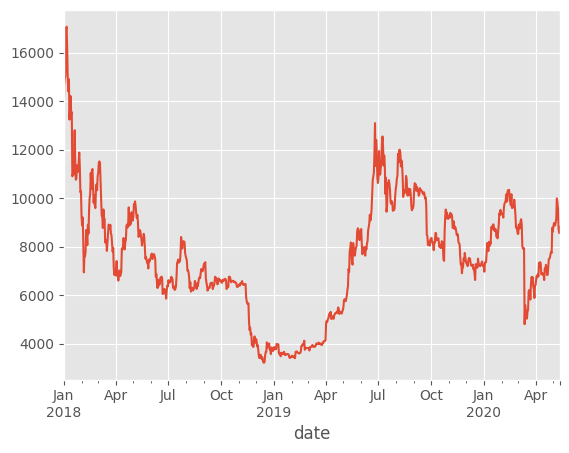

In [168]:
sliced_df['close'].plot()

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='date'>

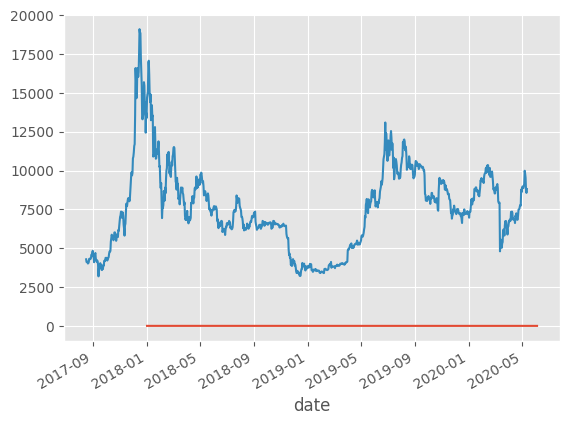

In [177]:
import yfinance as yf

# Download data for US Federal Funds Rate
fed_funds_data = yf.download("^IRX", start="2018-01-01", end="2020-06-05")

# Access closing prices (daily interest rates)
daily_rates = fed_funds_data["Close"]

# Print the first few daily rates
daily_rates.plot()
df['close'].plot()

In [189]:
close_price = np.array(df['close']).reshape(-1,1)

In [190]:
from sklearn.preprocessing import MinMaxScaler
preprocessor = MinMaxScaler()
df['close_scaled'] = preprocessor.fit_transform(close_price)


<Axes: xlabel='date'>

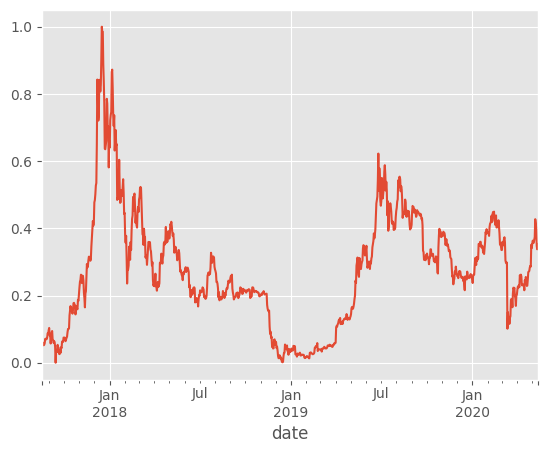

In [191]:
df['close_scaled'].plot()

In [176]:
sliced_df = df.loc['2018-01-01':]
sliced_df


,date,open,high,low,close,volume
date,,,,,,


<Axes: xlabel='date'>

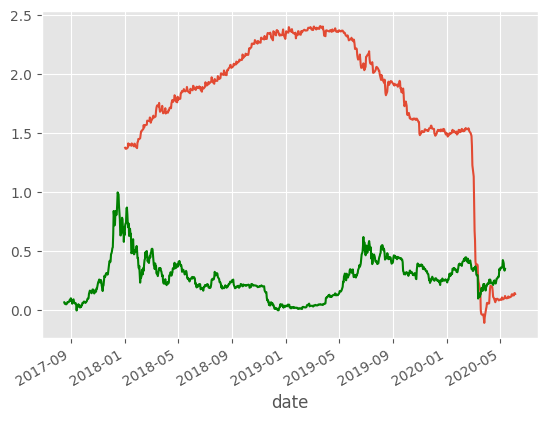

In [193]:
daily_rates.plot()
df['close_scaled'].plot( color='green')

In [194]:
import requests
import pandas as pd

# Define the API endpoint and parameters
api_url = "https://api.example.com/ftse-global-digital-asset-index"
params = {
    'index': 'FTSE_GLOBAL_DIGITAL_ASSET_50',
    'start_date': '2023-01-01',
    'end_date': '2023-12-31'
}

# Fetch the data
response = requests.get(api_url, params=params)
data = response.json()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data['prices'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Display the DataFrame
print(df.head())


ConnectionError: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /ftse-global-digital-asset-index?index=FTSE_GLOBAL_DIGITAL_ASSET_50&start_date=2023-01-01&end_date=2023-12-31 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001712601E890>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [199]:
import requests
import json

try:
  # Your code to fetch data (replace with your actual API call)
  response = requests.get("https://api.example.com/ftse-global-digital-asset-index")
  data = response.json()  # This line might raise the JSONDecodeError

  # Process the data here (assuming it's valid JSON)
  print(data["key"])  # Access data from the JSON object

except Exception as e:
  print("Error: Could not parse JSON data!")
  print(f"Reason: {e}")  # Print the error message for debugging


Error: Could not parse JSON data!
Reason: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /ftse-global-digital-asset-index (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000171279A9BA0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))


In [204]:
import requests
import json
from json import JSONDecodeError

try:
  response = requests.get("https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/historical")
  data = response.json()  # This line might raise the JSONDecodeError or other exceptions

  # Process the data here (assuming it's valid JSON)
  print(data)  # Access data from the JSON object

except requests.exceptions.RequestException as e:
  # Handle different request exceptions
  if isinstance(e, requests.exceptions.ConnectionError):
    print("Error: Could not connect to the API server!")
    print(f"Reason: {e}")  # Print the connection error details
  elif isinstance(e, requests.exceptions.Timeout):
    print("Error: API request timed out!")
  else:
    print(f"An error occurred while making the API request: {e}")

except JSONDecodeError as e:
  print("Error: Could not parse JSON data!")
  print(f"Reason: {e}")  # Print the JSON parsing error for debugging


{'status': {'timestamp': '2024-06-05T16:20:05.848Z', 'error_code': 1002, 'error_message': 'API key missing.', 'elapsed': 0, 'credit_count': 0}}


In [211]:
def global_var():
    global new_var 
    new_var = 4; 
    return new_var 

# global_var()

In [212]:
global_var(15)

4

In [213]:

class MyClass:
    class_var = 10  # Class variable (shared)

    def __init__(self, value):
        self.instance_var = value  # Instance variable

    def some_method(self):
        print("Class variable:", MyClass.class_var)  # No `global` needed
        print("Class attribute:", MyClass.shared_data)  # No `global` needed
        print("Instance variable:", self.instance_var)

# Set class-level attribute
MyClass.shared_data = "Global value"

obj1 = MyClass(20)
obj2 = MyClass(30)

obj1.some_method()
obj2.some_method()


Class variable: 10
Class attribute: Global value
Instance variable: 20
Class variable: 10
Class attribute: Global value
Instance variable: 30


In [215]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define the neural network model
model = Sequential()

# Input layer (flattening the input)
model.add(Flatten(input_shape=(6, 16)))  # 6 time steps, 16 features per time step

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer (example with a single output, e.g., future price or action value)
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()


d:\RL-Project\Py310-venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,057 (113.50 KB)

 Trainable params: 29,057 (113.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def traditional_opportunity_cost(current_balance, initial_balance, max_steps, current_step):
  """
  Calculates opportunity cost based on traditional definition.

  Args:
      current_balance (float): The current account balance.
      initial_balance (float): The initial account balance.
      max_steps (int): The maximum number of steps (e.g., investment period).
      current_step (int): The current step in the investment period.

  Returns:
      float: The opportunity cost.
  """

  # Check for zero initial balance to avoid division by zero
  if initial_balance == 0:
    return 0

  # Calculate the potential return if invested elsewhere
  potential_return = (max_steps - current_step) * (current_balance - initial_balance) / initial_balance

  return potential_return



def custom_opportunity_cost(current_balance, max_steps, current_step):
  """
  Calculates opportunity cost based on the custom definition.

  Args:
      current_balance (float): The current account balance.
      max_steps (int): The maximum number of steps (e.g., investment period).
      current_step (int): The current step in the investment period.

  Returns:
      float: The opportunity cost.
  """

  # Avoid division by zero
  if current_step == 0:
    return 0

  return current_balance * current_step / max_steps


In [3]:
import pandas as pd
import requests
import numpy as np

# Function to fetch data from FRED API
def fetch_interest_rate_data(api_key, series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    data = response.json()
    if 'observations' not in data:
        raise KeyError("'observations' not found in the API response")
    observations = data['observations']
    dates = [obs['date'] for obs in observations]
    values = [float(obs['value']) for obs in observations]
    return pd.DataFrame({'date': dates, 'interest_rate': values})

# Your FRED API key
api_key = 'your_fred_api_key'
series_id = 'DFF'  # This is the FRED series ID for the Federal Funds Rate
start_date = '2018-01-01'
end_date = '2023-12-31'

try:
    # Fetch the interest rate data
    interest_rate_df = fetch_interest_rate_data(api_key, series_id, start_date, end_date)
    interest_rate_df['date'] = pd.to_datetime(interest_rate_df['date'])
    interest_rate_df.set_index('date', inplace=True)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"Error: {e}")

# Assume you already have your daily OHLC data in a DataFrame called ohlc_df
# Example OHLC DataFrame structure
ohlc_df = pd.DataFrame({
    'date': pd.date_range(start='2018-01-01', end='2023-12-31', freq='B'),
    'open': 100 + np.random.randn(1516).cumsum(),
    'high': 100 + np.random.randn(1516).cumsum(),
    'low': 100 + np.random.randn(1516).cumsum(),
    'close': 100 + np.random.randn(1516).cumsum()
})
ohlc_df['date'] = pd.to_datetime(ohlc_df['date'])
ohlc_df.set_index('date', inplace=True)

if 'interest_rate_df' in locals():
    # Merge and backfill the interest rate data to match the OHLC data frequency
    merged_df = ohlc_df.merge(interest_rate_df, left_index=True, right_index=True, how='left')
    merged_df['interest_rate'].fillna(method='bfill', inplace=True)

    # Display the merged DataFrame
    print(merged_df.head(10))
else:
    print("Interest rate data was not successfully fetched.")


Error: Failed to fetch data: 400


ValueError: All arrays must be of the same length